<b>Data Preporcessing</b>

Some of the data columns have unexpected characters with the value. To make them clean and ready for use, it is required to convert them into numeric values. The following function- getNeumeric() does this task of conversion. It takes a string and returns the numeric value after removing all the unexpected or unformatted characters.

In [1]:
import re
def getNeumeric(v):
    neumeric = 0
    if not (v is None):
        x = re.sub("[^0-9]", "",v)
        if(len(x) == 0):
            x = 0
        neumeric = int(x)
        #print("Original--------:", v, " ; Neumeric--------: ", neumeric)
    return neumeric

print(getNeumeric(" 50000000,00,0+ "))

50000000000


The App Size data column value is continuous, and it ranges from 0.2 to around 500 megabytes. To make the analysis better, values are converted into several meaningful categories. The following extractAppSize() function takes the app size value as input and returns the value for one of nine classes.

In [2]:
import re
def extractAppSize(v):
    size = 0
    size_in_mb = "Less than 1Kb"
    if v == "Varies with device":
        return "Varies with device"
    elif v.endswith("k") or v.endswith("K") or v.endswith("Kb") or v.endswith("kb"):
        size = 1
    else:
        x = re.sub("[^0-9.]", "",v)
        if(len(x) == 0):
            x = 0
        size = float(x)

    if size <= 1:
        size_in_mb = "Less than 1Mb"
    elif size <= 3:
        size_in_mb = "1Mb - 3.00Mb"
    elif size <= 5:
        size_in_mb = "3.01Mb - 5.00Mb"
    elif size <= 10:
        size_in_mb = "5.01Mb - 10.00Mb"
    elif size <= 20:
        size_in_mb = "10.01Mb - 20.00Mb"
    elif size <= 30:
        size_in_mb = "20.01Mb - 30.00Mb"
    elif size <= 50:
        size_in_mb = "30.01Mb - 50.00Mb"
    elif size <= 100:
        size_in_mb = "50.01Mb - 100Mb"
    else:
        size_in_mb = "Larger than 100Mb"
        
    return size_in_mb

print(extractAppSize("Varies with device"))
print(extractAppSize("1.2M"))
print(extractAppSize("11.2M"))
print(extractAppSize("192k"))


Varies with device
1Mb - 3.00Mb
10.01Mb - 20.00Mb
Less than 1Mb


The following one is the reduce function for MapReduce algorithm. It adds to given values.

In [3]:
def addValues(val1, val2):
    return val1 + val2

<b>PySpark- MapReduce</b>

Here the data is loaded, and MapReduce is applied. The following loadData() function loads the raw data from the google play store data text file. After splitting the CSV data, the headers are excluded. Then MapReduce is applied, and the result is returned in a key-value pair RDD format. Data are reduced by different keys. For the key value, we use different categories like- App Category, App Size, Content Rating, App Type etc. For the value mostly we choose the number of app installs.

In [5]:
from pyspark import SparkContext
import numpy as np

sc = SparkContext.getOrCreate()

# Function loads a google play store data text file and separates each row into (key, value) pair
# Input: fileName: 'location/of/file.csv'
#        delimiter: 'delimiter string', default=','
# Return: [list of RDD <<(key, value), (key, value), ...>>
def loadData(fileName, delimiter=','):
    # Load data values
    csv_data = sc.textFile(fileName)
    split_data = csv_data.map(lambda x: x.split(delimiter))
    
    # Separate header from data
    header = split_data.first()
    data = split_data.filter(lambda x: x!=header)
    
    # Fill missing values with marker values (i.e., np.nan)
    missing_data = data.map(lambda x: [val if val!='' else np.nan for val in x])

    # Map the data to (key, value) pairs
    data_category = missing_data.map(lambda x: (x[1], getNeumeric(x[5])))
    data_type = missing_data.map(lambda x: (x[6], getNeumeric(x[5])))
    data_content_rating = missing_data.map(lambda x: (x[8], getNeumeric(x[5])))
    data_android_version = missing_data.map(lambda x: (x[12], getNeumeric(x[5])))
    data_app_size = missing_data.map(lambda x: (extractAppSize(x[4]), getNeumeric(x[5])))

    return data_category, data_type, data_content_rating, data_android_version, data_app_size


data_category, data_type, data_content_rating, data_android_version, data_app_size = loadData('googleplaystore_v2.csv')

#print and test the reuslt
counter = 0
for d in data_content_rating.collect()[5000:5500]:
    print(counter, d)
    counter+=1

0 ('Everyone', 50000)
1 ('Everyone', 500000)
2 ('Teen', 1000000)
3 ('Everyone', 100000)
4 ('Everyone', 1000000)
5 ('Everyone', 100000)
6 ('Teen', 1000000)
7 ('Teen', 50000)
8 ('Everyone', 50000)
9 ('Everyone', 500000)
10 ('Teen', 100000)
11 ('Everyone', 1000000)
12 ('Everyone', 1000)
13 ('Everyone', 10000)
14 ('Everyone', 5000000)
15 ('Everyone', 1000)
16 ('Everyone', 1000)
17 ('Everyone 10+', 100000)
18 ('Everyone 10+', 100000)
19 ('Everyone', 10000)
20 ('Everyone', 10000)
21 ('Everyone 10+', 10000)
22 ('Everyone', 10000)
23 ('Everyone', 10)
24 ('Everyone', 10000000)
25 ('Everyone', 10000)
26 ('Everyone', 10000)
27 ('Everyone', 1000000)
28 ('Everyone', 500000)
29 ('Everyone', 100)
30 ('Everyone', 50000)
31 ('Everyone', 10000)
32 ('Everyone', 1000)
33 ('Everyone', 5000000)
34 ('Everyone', 1000)
35 ('Everyone', 10000)
36 ('Everyone', 1000)
37 ('Everyone', 10000000)
38 ('Everyone', 10000)
39 ('Everyone', 10000)
40 ('Everyone', 5000)
41 ('Everyone', 100)
42 ('Everyone', 10000000)
43 ('Eve

Mapped data are reduced by the key- App Category. And the value is number of app installs.

In [6]:
reduced_data = data_category.reduceByKey(addValues)

rSorted = reduced_data.sortBy(lambda x: x[1])
sorted_list = rSorted.collect()
sorted_list.reverse()
for i in sorted_list:
    print(i[0], i[1])

GAME 35086024415
COMMUNICATION 32647276251
PRODUCTIVITY 14176091369
SOCIAL 14069867902
TOOLS 11452771915
FAMILY 10258263505
PHOTOGRAPHY 10088247655
NEWS_AND_MAGAZINES 7496317760
TRAVEL_AND_LOCAL 6868887146
VIDEO_PLAYERS 6222002720
SHOPPING 3247848785
ENTERTAINMENT 2869160000
PERSONALIZATION 2325494782
BOOKS_AND_REFERENCE 1921469576
SPORTS 1751174498
HEALTH_AND_FITNESS 1583072512
BUSINESS 1001914865
FINANCE 876648734
EDUCATION 871452000
MAPS_AND_NAVIGATION 724281890
LIFESTYLE 537643539
WEATHER 426100520
FOOD_AND_DRINK 273898751
DATING 264310807
HOUSE_AND_HOME 168712461
ART_AND_DESIGN 124338100
LIBRARIES_AND_DEMO 62995910
COMICS 56086150
MEDICAL 53257437
AUTO_AND_VEHICLES 53130211
PARENTING 31521110
BEAUTY 27197050
EVENTS 15973161
1.9 0


The result for App category vs total installs is visualized using matplotlib

BEAUTY 27197050
COMICS 56086150
COMMUNICATION 32647276251
EDUCATION 871452000
EVENTS 15973161
FINANCE 876648734
FOOD_AND_DRINK 273898751
HOUSE_AND_HOME 168712461
PHOTOGRAPHY 10088247655
TRAVEL_AND_LOCAL 6868887146
PARENTING 31521110
VIDEO_PLAYERS 6222002720
NEWS_AND_MAGAZINES 7496317760
MAPS_AND_NAVIGATION 724281890
ART_AND_DESIGN 124338100
AUTO_AND_VEHICLES 53130211
BOOKS_AND_REFERENCE 1921469576
BUSINESS 1001914865
DATING 264310807
ENTERTAINMENT 2869160000
HEALTH_AND_FITNESS 1583072512
LIBRARIES_AND_DEMO 62995910
LIFESTYLE 537643539
GAME 35086024415
FAMILY 10258263505
MEDICAL 53257437
SOCIAL 14069867902
SHOPPING 3247848785
SPORTS 1751174498
TOOLS 11452771915
PERSONALIZATION 2325494782
PRODUCTIVITY 14176091369
WEATHER 426100520


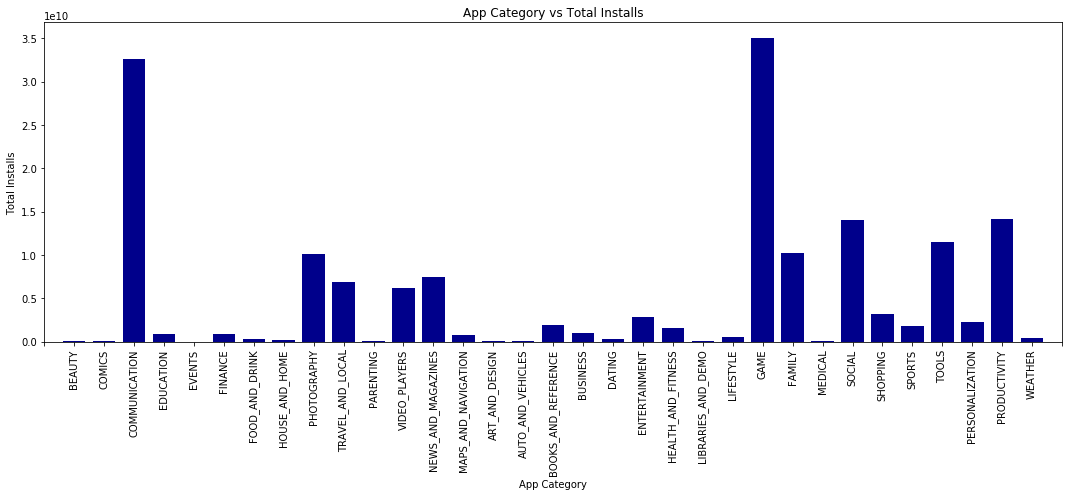

In [8]:
from matplotlib import pyplot as plt

category = data_category.reduceByKey(addValues)
filtered_category = category.filter(lambda x: x[1] != 0)

for item in filtered_category.collect():
    print(item[0], item[1])
    
X_vals, Y_vals = zip(*filtered_category.collect())
plt.figure(figsize=(15, 7))  # width:11, height:5

plt.bar(X_vals, Y_vals, 0.75, color = 'darkblue')
plt.xlim((.125, len(X_vals)))
plt.xticks(range(-1,len(X_vals)+1,1), rotation='vertical')
plt.xlabel('App Category')
plt.ylabel('Total Installs')
plt.title('App Category vs Total Installs')
plt.tight_layout()
plt.savefig(fname="category_darkblue.png")
plt.show()

Mapped data are reduced by the key- Content Rating. And the value is number of app installs. Result is depicted using the bar chart with the help of matplotlib.

Everyone 10+ 13233881795
Adults only 18+ 2000000
Unrated 50500
Everyone 114156659621
Teen 34716350393
Mature 17+ 5524491178


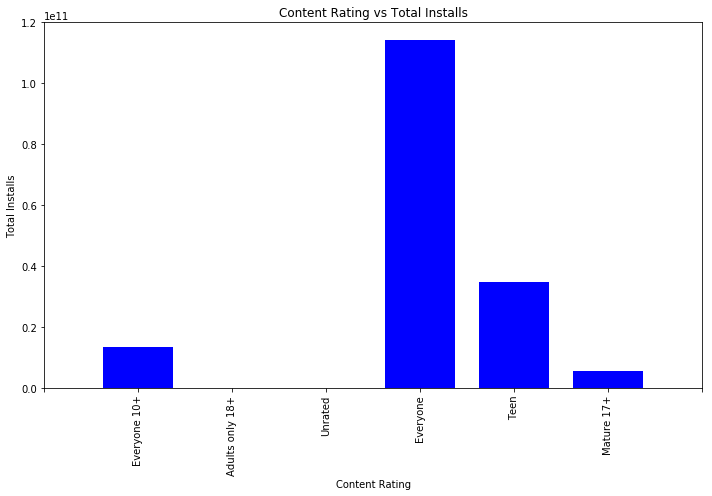

In [9]:
from matplotlib import pyplot as plt

content_rating = data_content_rating.reduceByKey(addValues)
filtered_content_rating = content_rating.filter(lambda x: x[1] != 0)

for item in filtered_content_rating.collect():
    print(item[0], item[1])
    
X_vals, Y_vals = zip(*filtered_content_rating.collect())
plt.figure(figsize=(10, 7))  # width:11, height:5

plt.bar(X_vals, Y_vals, 0.75, color = 'blue')
plt.xlim((.125, len(X_vals)))
plt.xticks(range(-1,len(X_vals)+1,1), rotation='vertical')
plt.xlabel('Content Rating')
plt.ylabel('Total Installs')
plt.title('Content Rating vs Total Installs')
plt.tight_layout()
plt.savefig(fname="content_rating_blue.png")
plt.show()

Mapped data are reduced by the key- App Type (Free or Paid). And the value is number of app installs. Result is depicted using the pie chart with the help of matplotlib.

Free 167560477406
Paid 72956081
0.04354014868507864 %


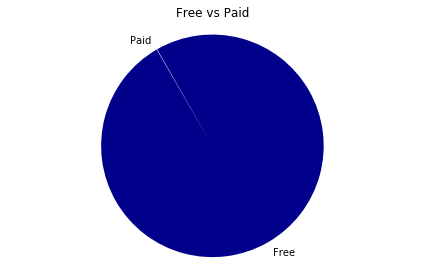

In [12]:
from matplotlib import pyplot as plt

app_type = data_type.reduceByKey(addValues)
filtered_app_type = app_type.filter(lambda x: x[1] != 0)

for item in filtered_app_type.collect():
    print(item[0], item[1])

print((72956081 * 100 / 167560477406),"%")
X_vals, Y_vals = zip(*filtered_app_type.collect())

fig1, ax1 = plt.subplots()
ax1.pie(Y_vals, labels=X_vals, startangle=120, colors=['darkblue', 'white'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Free vs Paid")
plt.tight_layout()
plt.savefig(fname="type_darkblue.png")
plt.show()

Here the Android version is also a categorial data. Mapped data are reduced by the key- Android Version. And the value is number of app installs. Result is depicted using the bar chart with the help of matplotlib.

4.2 and up 1996412654
4.4 and up 11919907598
2.3 and up 2751627409
4.0 and up 13525890206
Varies with device 93238228782
2.2 and up 97092235
1.5 and up 23841710
7.0 and up 223509600
5.1 and up 8421760
4.0.3 - 7.1.1 15000000
2.0 and up 35512910
3.2 and up 8305725
4.4W and up 37270
7.0 - 7.1.1 1000000
2.0.1 and up 101070060
4.1 - 7.1.1 100000000
5.0 - 6.0 10000
1.0 and up 60000
2.2 - 7.1.1 100
5.0 - 7.1.1 5
4.0.3 and up 7525768043
3.0 and up 571815241
4.1 and up 30722431989
2.3.3 and up 885302515
5.0 and up 2254682543
6.0 and up 72746391
1.6 and up 46413652
2.1 and up 315531257
4.3 and up 1019205721
7.1 and up 101050000
8.0 and up 1510106
5.0 - 8.0 20000000
3.1 and up 51037005
NaN 11000


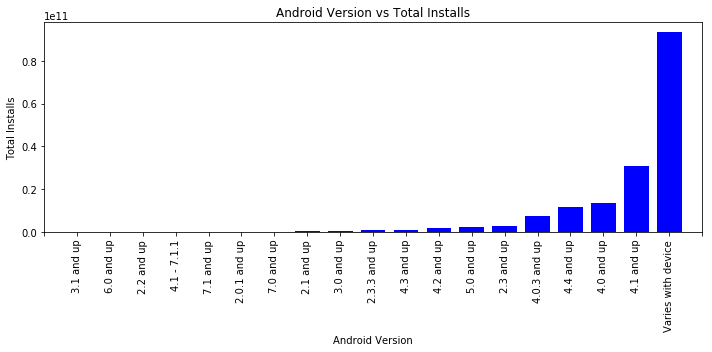

In [13]:
from matplotlib import pyplot as plt

android_version = data_android_version.reduceByKey(addValues)
filtered_android_version = android_version.filter(lambda x: x[1] != 0)

rSorted = filtered_android_version.sortBy(lambda x: x[1])
for item in filtered_android_version.collect():
    print(item[0], item[1])
    
X_vals, Y_vals = zip(*rSorted.collect()[15:])
plt.figure(figsize=(10, 5))  # width:11, height:5

plt.bar(X_vals, Y_vals, 0.75, color = 'blue')
plt.xlim((.125, len(X_vals)))
plt.xticks(range(-1,len(X_vals)+1,1), rotation='vertical')
plt.xlabel('Android Version')
plt.ylabel('Total Installs')
plt.title('Android Version vs Total Installs')
plt.tight_layout()
plt.savefig(fname="version_blue.png")
plt.show()

Mapped data are reduced by the key- App Size. And the value is number of app installs. Result is depicted using the bar chart with the help of matplotlib.

10.01Mb - 20.00Mb 13623591465
1Mb - 3.00Mb 684863478
20.01Mb - 30.00Mb 5930922144
3.01Mb - 5.00Mb 1328412624
30.01Mb - 50.00Mb 9420339907
5.01Mb - 10.00Mb 2888912539
50.01Mb - 100Mb 31058472833
Less than 1Mb 129718474
Varies with device 102568200023


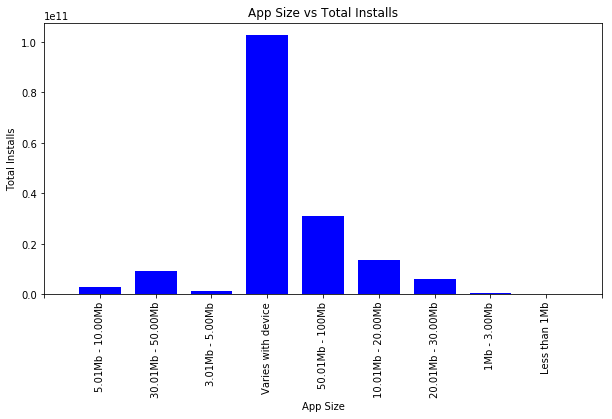

In [14]:
from matplotlib import pyplot as plt

app_size = data_app_size.reduceByKey(addValues)
filtered_app_size = app_size.filter(lambda x: x[1] != 0)

rSorted = filtered_app_size.sortBy(lambda x: x[0])
for item in rSorted.collect():
    print(item[0], item[1])
    
X_vals, Y_vals = zip(*filtered_app_size.collect())
plt.figure(figsize=(10, 5))  # width:11, height:5

plt.bar(X_vals, Y_vals, 0.75, color = 'blue')
plt.xlim((.125, len(X_vals)))
plt.xticks(range(-1,len(X_vals)+1,1), rotation=90)
plt.xlabel('App Size')
plt.ylabel('Total Installs')
plt.title('App Size vs Total Installs')
plt.show()

We also try to show the result for App size vs installs with a pie chart. But the result was not good. Some of fields overlapped. 

10.01Mb - 20.00Mb 13623591465
1Mb - 3.00Mb 684863478
20.01Mb - 30.00Mb 5930922144
3.01Mb - 5.00Mb 1328412624
30.01Mb - 50.00Mb 9420339907
5.01Mb - 10.00Mb 2888912539
50.01Mb - 100Mb 31058472833
Less than 1Mb 129718474
Varies with device 102568200023


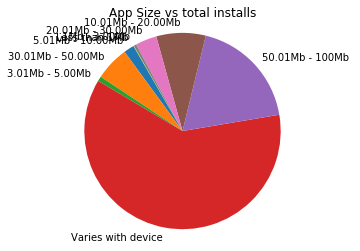

In [15]:
from matplotlib import pyplot as plt

app_size = data_app_size.reduceByKey(addValues)
filtered_app_size = app_size.filter(lambda x: x[1] != 0)

rSorted = filtered_app_size.sortBy(lambda x: x[0])
for item in rSorted.collect():
    print(item[0], item[1])
    
X_vals, Y_vals = zip(*filtered_app_size.collect())

fig1, ax1 = plt.subplots()
ax1.pie(Y_vals, labels=X_vals, startangle=120)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("App Size vs total installs")
plt.show()

The following function converts an unformatted string into a float with the help of regular expression.

In [12]:
import re
def getFloat(v):
    neumeric = 0
    if not (v is None):
        x = re.sub("[^0-9.]", "",v)
        if(len(x) == 0):
            x = 0
        neumeric = x
        #print("Original--------:", v, " ; Neumeric--------: ", neumeric)
    return neumeric

print(getFloat(" 50.000000,00,0+ "))

50.000000000


<b> K-Means Clustering</b>

The default k means with the spark library is used here that we followed for our class assignment. Mainly I tried to see the relationships among numeric columns using K-Means clustering. In the beginning, the data cleaning part is done, after that the mapping.

In [13]:
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

def loadData(fileName, delimiter=','):
    # Load data values
    csv_data = sc.textFile(fileName)
    split_data = csv_data.map(lambda x: x.split(delimiter))
    
    # Separate header from data
    header = split_data.first()
    data = split_data.filter(lambda x: x!=header)
    
    # Fill missing values with marker values (i.e., np.nan)
    data_all = data.map(lambda x: [val if val!='' else np.nan for val in x])

    # Map the data to (key, value) pairs
    data_kv = data_all.map(lambda x: ((x[0]), np.array((getFloat(x[2]),getNeumeric(x[3])), dtype='float32')))
    data_kv_2 = data_all.map(lambda x: ((x[0]), np.array((getFloat(x[2]), getNeumeric(x[3]), getNeumeric(x[5])), dtype='float32')))
    header_kv = [(header[0]), (header[2], header[3])] # Match header to kmeans_data

    return data_kv, data_kv_2, header_kv


# Load the data in the first file
app_data_set, app_data_set_2, header = loadData('googleplaystore_v2.csv')

print(header)
counter = 0
for d in app_data_set_2.collect()[:100]:
    print(counter, d)
    counter+=1

['App', ('Rating', 'Reviews')]
0 ('Photo Editor & Candy Camera & Grid & ScrapBook', array([4.10e+00, 1.59e+02, 1.00e+04], dtype=float32))
1 ('Coloring book moana', array([3.90e+00, 9.67e+02, 5.00e+05], dtype=float32))
2 ('U Launcher Lite – FREE Live Cool Themes Hide Apps', array([4.700e+00, 8.751e+04, 5.000e+06], dtype=float32))
3 ('Sketch - Draw & Paint', array([4.50000e+00, 2.15644e+05, 5.00000e+07], dtype=float32))
4 ('Pixel Draw - Number Art Coloring Book', array([4.30e+00, 9.67e+02, 1.00e+05], dtype=float32))
5 ('Paper flowers instructions', array([4.40e+00, 1.67e+02, 5.00e+04], dtype=float32))
6 ('Smoke Effect Photo Maker - Smoke Editor', array([3.80e+00, 1.78e+02, 5.00e+04], dtype=float32))
7 ('Infinite Painter', array([4.1000e+00, 3.6815e+04, 1.0000e+06], dtype=float32))
8 ('Garden Coloring Book', array([4.4000e+00, 1.3791e+04, 1.0000e+06], dtype=float32))
9 ('Kids Paint Free - Drawing Fun', array([4.70e+00, 1.21e+02, 1.00e+04], dtype=float32))
10 ('Text on Photo - Fonteee', ar

KMeans from the pyspark is applied

In [14]:
from pyspark.mllib.clustering import KMeans

# Get data values (i.e., drop keys)
app_data_values = app_data_set.map(lambda x: x[1])

# Cluster app data using k-Means and K=5
K = 5
model = KMeans.train(app_data_values, K, maxIterations=10, initializationMode='random')

# Look at the location of cluster centers
# HINT: ref [1]
print(model.clusterCenters)

# Show the cluster id of 10 randomply chosen data points
# HINT: ref [2]
cluster_ids = model.predict(app_data_values)
print(cluster_ids.takeSample(False, 10))



[array([4.38235291e+00, 6.01343753e+07]), array([4.42606926e+00, 2.58463983e+06]), array([4.36352459e+00, 4.03229957e+05]), array([3.46076062e+00, 1.36390197e+04]), array([4.44277458e+00, 1.10370029e+07])]
[3, 3, 3, 3, 3, 3, 3, 2, 3, 3]


Find the best value for k using elbow method

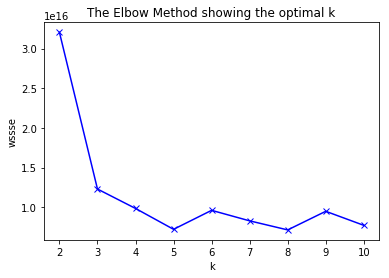

In [15]:
from matplotlib import pyplot as plt

# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
K = []
w = []

for k in range(2,11):
    K.append(k)
    model = KMeans.train(app_data_values, k, maxIterations=10, initializationMode='random')
    wssse = model.computeCost(app_data_values)
    w.append(wssse)
    
plt.plot(K, w, 'xb-')
    
plt.xlabel('k')
plt.ylabel('wssse')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Here we plot the result of KMeans clustering. The result was not good when we tried without data standardization. After doing the data standardization, we got a pretty good cluster.

[array([  3.9, 967. ], dtype=float32), array([4.700e+00, 8.751e+04], dtype=float32), array([4.50000e+00, 2.15644e+05], dtype=float32), array([  4.3, 967. ], dtype=float32)]


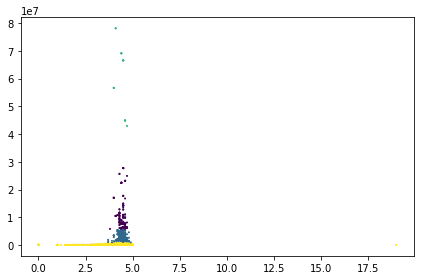

<Figure size 432x288 with 0 Axes>

In [16]:

def plotTheClusters(plot_data, cluster_ids):

    data_array = np.array(plot_data.collect())
    plt.scatter(data_array[:,0], data_array[:,1], c=cluster_ids, s=1)
    plt.tight_layout()
    plt.savefig(fname='kmeans')   
    plt.show()
    plt.clf()


def clusterAndPlotData(km_data, K = 5):
    print(km_data.collect()[1:5])
    
    # Cluster the data using kMeans and input K value
    model = KMeans.train(km_data, K, maxIterations=10, initializationMode='random')
    
    # Get the cluster ID for each data item in the dataset.  
    # Cluster ID values are used to show clusters with color in plots
    cluster_ids = model.predict(km_data)

    # Plot food clusters
    plotTheClusters(km_data, cluster_ids.collect())


# Define the optimal K value we found above.  It will be used for the remainder of the assignment!
K = 4

# Cluster and plot food data
clusterAndPlotData(app_data_values, K)

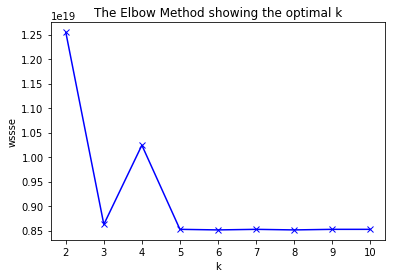

In [17]:
from matplotlib import pyplot as plt

# Train k-Means with k values in [2,10] and calculate WSSSE for each clustering
K = []
w = []
app_data_values = app_data_set_2.map(lambda x: x[1])
for k in range(2,11):
    K.append(k)
    model = KMeans.train(app_data_values, k, maxIterations=10, initializationMode='random')
    wssse = model.computeCost(app_data_values)
    w.append(wssse)
    
plt.plot(K, w, 'xb-')
    
plt.xlabel('k')
plt.ylabel('wssse')
plt.title('The Elbow Method showing the optimal k')
plt.show()

[array([3.90e+00, 9.67e+02, 5.00e+05], dtype=float32), array([4.700e+00, 8.751e+04, 5.000e+06], dtype=float32), array([4.50000e+00, 2.15644e+05, 5.00000e+07], dtype=float32), array([4.30e+00, 9.67e+02, 1.00e+05], dtype=float32)]


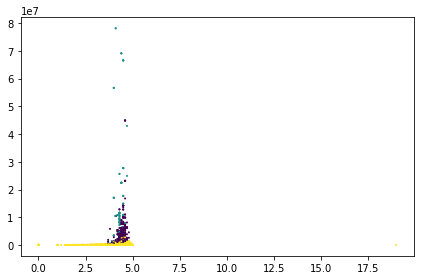

<Figure size 432x288 with 0 Axes>

In [18]:
clusterAndPlotData(app_data_values, 3)

For better clustering, we tried to standardize the data. This time the result was pretty good.

[(3.9, -0.15137317395474606), (4.7, -0.12181102582902702), (4.5, -0.07804184417434805), (4.3, -0.15137317395474606)]


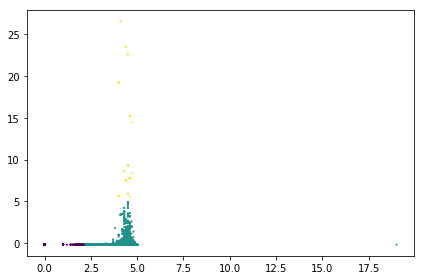

<Figure size 432x288 with 0 Axes>

In [19]:
import stats
app_data_values = stats.Standardize(app_data_values)
clusterAndPlotData(app_data_values, 3)

<b> Heat Map</b>

At the final part, we tried to see the correlation among the numeric data columns of our data. We used pandas and seaborn to generate the heat map.

In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('googleplaystore_v2.csv')

#there is value '3.0M' which should not be in reviews column so we drop this column
data.drop(data.Reviews[data.Reviews == '3.0M'].index, inplace = True)

#replace space with _ so there is no gap between words in column names
data.columns = data.columns.str.replace(' ','_')
#make Reviews number
data.Reviews = pd.to_numeric(data.Reviews ,downcast='integer')
#make Last update date time format
data.Last_Updated= pd.to_datetime(data.Last_Updated)
#add new column called size_number. Sizes are in kilobytes
data['Size_number'] = data.Size.str.replace('M','000')
data.Size_number = data.Size_number.str.replace('k','')
data.Size_number = data.Size_number.replace('Varies with device', np.NaN)
data.Size_number = pd.to_numeric(data.Size_number, downcast = 'integer')
#make installs number
data.Installs = data.Installs.str.replace('+','')
data.Installs = data.Installs.str.replace(',','')
data.Installs = pd.to_numeric(data.Installs,downcast = 'integer')
#make price float
data.Price = data.Price.str.replace('$','')
data.Price = pd.to_numeric(data.Price)
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last_Updated,Current_Ver,Android_Ver,Size_number
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,10000,Free,0.0,Everyone,Art & Design,2018-01-07,1.0.0,4.0.3 and up,19000.0
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,500000,Free,0.0,Everyone,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up,14000.0
2,U Launcher Lite – FREE Live Cool Themes Hide Apps,ART_AND_DESIGN,4.7,87510,8.7M,5000000,Free,0.0,Everyone,Art & Design,2018-08-01,1.2.4,4.0.3 and up,8.7
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,50000000,Free,0.0,Teen,Art & Design,2018-06-08,Varies with device,4.2 and up,25000.0
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,100000,Free,0.0,Everyone,Art & Design;Creativity,2018-06-20,1.1,4.4 and up,2.8


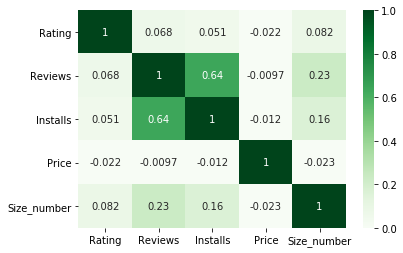

In [23]:
sns.heatmap(data.corr(),vmax = 1, vmin = 0,annot = True, cmap="Greens")
plt.show()